## Classifying Music Genres Using Echo Nest Data

Want to Answer the question: "Can we accurately classify music tracks as either Hip-Hop or Rock using machine learning?"

Need to preprocess and balance the dataset, apply PCA for dimensionality reduction, and use decision tree and logistic regression models to classify the tracks, evaluating the model performance using cross-validation.

## 0. Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline



## 1. Datasets

In [3]:
# read in data
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', precise_float=True)
# merge the relevant on track_id col
echo_tracks = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')

echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


## 2. EDA
To maintain efficiency and clarity in our models, we avoid using data points that are too similar, identifying such redundancies with a correlational matrix

In [4]:
corr_metrics = echonest_metrics.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.279829,0.102056,0.121991,-0.283206,-0.004059,-0.075077,0.004313,0.020201
acousticness,-0.279829,1.000000,-0.189599,-0.477273,0.110033,0.041319,0.038785,-0.110701,-0.085436
danceability,0.102056,-0.189599,1.000000,0.045345,-0.118033,-0.143339,0.171311,-0.094352,0.428515
energy,0.121991,-0.477273,0.045345,1.000000,-0.002412,0.045752,-0.008645,0.227324,0.219384
instrumentalness,-0.283206,0.110033,-0.118033,-0.002412,1.000000,-0.058593,-0.216689,0.023003,-0.145200
liveness,-0.004059,0.041319,-0.143339,0.045752,-0.058593,1.000000,0.073104,-0.007566,-0.017886
speechiness,-0.075077,0.038785,0.171311,-0.008645,-0.216689,0.073104,1.000000,0.032188,0.094794
tempo,0.004313,-0.110701,-0.094352,0.227324,0.023003,-0.007566,0.032188,1.000000,0.129911
valence,0.020201,-0.085436,0.428515,0.219384,-0.145200,-0.017886,0.094794,0.129911,1.000000


## 3. Splitting our data
Since we found no strong correlations between our features, we can proceed to split our data into two arrays: one for features and another for labels, which is the genre of the track, and then apply preprocessing steps to optimize our model development.

In [5]:
# features
features = echo_tracks.drop(["genre_top", "track_id"], axis=1).values

# labels
labels = echo_tracks["genre_top"].values

# train test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            random_state=10)

## 4. Normalizing the feature data
Since we didn't find strong correlations between our features, we can use principal component analysis (PCA) to reduce the number of features by rotating the data to highlight the most variance. However, PCA can be biased by features with wider value ranges, so we'll first standardize our features to have a mean of 0 and a standard deviation of 1, ensuring a fair comparison across all features.

In [6]:
# Scaling features (train and test)
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

## 5. PCA
Having preprocessed our data, we're ready to apply PCA to explore dimensionality reduction. We'll use scree-plots and cumulative explained ratio plots to determine the optimal number of components. Scree-plots, which plot components against the variance they explain, help us identify where the variance explained significantly drops off, known as the 'elbow', which indicates an appropriate cutoff for the number of components to use.

Text(0.5, 0, 'Principal Component #')

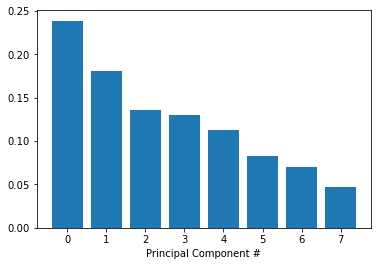

In [7]:
%matplotlib inline
# Explained variance (all features)
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plotting explained variance
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

## 6. Further visualization of PCA
Even though the scree plot doesn’t clearly show where to cut off, we can use the cumulative explained variance plot to help. By aiming to explain about 85% of the variance, we can figure out how many components to keep. This way, we can reduce our data’s complexity effectively while still capturing most of its important information.

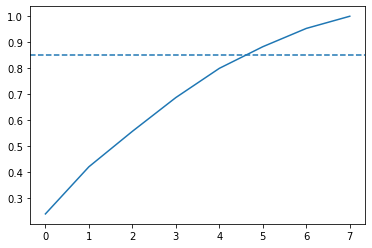

In [8]:
# cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# plotting with line at 0.85
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

## 7. Projecting on to our features
The plot showed that 6 features explain 85% of the variance. Thus, we can use these 6 components in PCA to effectively reduce the dimensionality of our train and test data.

In [9]:
# PCA with 6 components
pca = PCA(n_components=6, random_state=10)
train_pca = pca.fit_transform(scaled_train_features)
test_pca = pca.transform(scaled_test_features)

## 8. Train a decision tree to classify genre
Now, with the lower-dimensional PCA projection of our data, we can classify songs into genres using a decision tree. This simple, rule-based classifier uses a tree structure to make binary decisions and categorize data. Decision trees are user-friendly, interpretable, and provide a visual flowchart of how decisions are made based on training data. For example, a decision tree can classify shapes by considering attributes like the number of sides and orientation.

In [10]:
# decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

## 9. Compare our decision tree to a logistic regression
While our decision tree performs well, it's important not to assume it's the best option without exploring others. Next, we'll try logistic regression, which uses the logistic function to estimate the probability that a data point belongs to a specific class. By comparing the performance metrics of both models, like the false positive and false negative rates, we can determine which algorithm better suits our data.

In [11]:
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.63      0.62      0.62       235
        Rock       0.91      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.77      0.77      0.77      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



## 10. Balance our data for greater performance
Both our models have an average precision of 87%, but there's an issue with misclassification of hip-hop songs as rock. This likely occurs because our dataset contains more rock than hip-hop songs, leading the model to favor the rock classification. To improve the model's fairness, we can adjust the weights of each class in the model's calculations, giving greater importance to the underrepresented hip-hop class to balance the influence of each genre's data points. This adjustment aims to correct the skew caused by uneven sample sizes without altering the inherent value of each class.

In [12]:
# balanced subsetting
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# rock only
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concat hip_hop and rock dfs
rock_hop_bal = pd.concat([rock_only, hop_only])

# feature and label creation
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# set train and test set with pca balancing 
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

## 11. Does balancing our dataset improve model bias?
After balancing our dataset to address the model's bias toward the "Rock" classification, we need to test if this change retains overall classification performance while correcting the bias. While we've reduced the size of our dataset in the process, we'll proceed without further dimensionality reduction. Typically, we would apply more rigorous dimensionality reduction strategies in scenarios with very large datasets where computation time is a critical factor.

In [13]:
# trai decision tree on balanced data 
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# training logistic regression on  balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# comparison
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.82      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



## 12. Using cross-validation to evaluate our models
Balancing our dataset has successfully mitigated the bias towards the "Rock" classification. To rigorously evaluate our models, we'll implement cross-validation (CV), which provides a thorough comparison by testing the models across multiple splits of the data. We'll prepare for CV by setting up pipelines to scale our data, apply PCA, and choose a model, either the `DecisionTree22Classifier` or `LogisticRegression`. Using the K-fold CV method, we'll divide the data into equal subsets, cycling each as a test set while training on the remainder. This approach allows us to compile results from each test to give a comprehensive performance score of our models.

In [14]:
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

# 10-fold cross-validation
kf = KFold(10)

# training models with KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

# mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7582417582417582 Logistic Regression: 0.782967032967033


The results show that the Logistic Regression model performs better than the Decision Tree model for predicting labels, with accuracies of 78.30% and 75.82% respectively. This means that Logistic Regression is more accurate by about 2.5% in this case. The higher accuracy suggests it's a better choice for this particular dataset. These findings can guide which model to use for more reliable predictions.